In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict
import netwulf as nw

https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR5jxk4FClm9GBFvCklV4Ga5SRwON3ajfqLdOMjFqN1uereEEduffCtjEbkjJg_aem_YUf8t7fIjwbCWiHS_vrVcg

In [2]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')

nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])


In [3]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
        
        filtered_dfs.append(df)

    return filtered_dfs

pop_df, rap_df = split_artists_by_genre(nodes_df, ["pop", "rap"])

len(pop_df), len(rap_df)


(18232, 9397)

In [4]:
def get_Graph_with_names(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Build ID to name map
    id_to_name = dict(zip(nodes_df['spotify_id'], nodes_df['name']))
    allowed_ids = set(id_to_name.keys())

    # Create graph with artist names as nodes
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        artist_name = row['name']
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []

        G.add_node(artist_name, followers=followers, popularity=popularity,
                   genres=genres, chart_hits=chart_hits)

    for _, row in edges_df.iterrows():
        id_0, id_1 = row['id_0'], row['id_1']
        if id_0 in allowed_ids and id_1 in allowed_ids:
            name_0 = id_to_name.get(id_0)
            name_1 = id_to_name.get(id_1)
            if name_0 and name_1:
                G.add_edge(name_0, name_1)

    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
    
    communities = defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    return sorted_communities
        
def get_community_subgraph(G, community_id):
    nodes_in_community = [n for n, attr in G.nodes(data=True) if attr.get('community') == community_id]
    
    subgraph = G.subgraph(nodes_in_community).copy()
    
    return subgraph

def get_combined_louvain_splitted_graph(G):
    _G = G.copy()
    partition = community_louvain.best_partition(_G)
    nx.set_node_attributes(_G, partition, 'community')

    combined_G = nx.Graph()
    
    combined_G.add_nodes_from(_G.nodes(data=True))

    for u, v in _G.edges():
        if partition[u] == partition[v]:
            combined_G.add_edge(u, v, **_G[u][v])

    return combined_G

In [5]:
G_pop = get_Graph_with_names(pop_df, edges_df)
G_rap = get_Graph_with_names(rap_df, edges_df)

Number of nodes: 18085
Number of edges: 47851
Network density: 0.00029262269272440223
Number of nodes: 9320
Number of edges: 30560
Network density: 0.0007037171278209132


In [11]:
G_rap_splittet = get_combined_louvain_splitted_graph(G_rap)

In [12]:
sorted_communities = apply_louvain(G_rap, verbose=False)
largest_community_id = sorted_communities[0][0]
G_rap_largest_community = get_community_subgraph(G_rap, largest_community_id)

louvain_splitted_G_rap_largest_community = get_combined_louvain_splitted_graph(G_rap_largest_community)

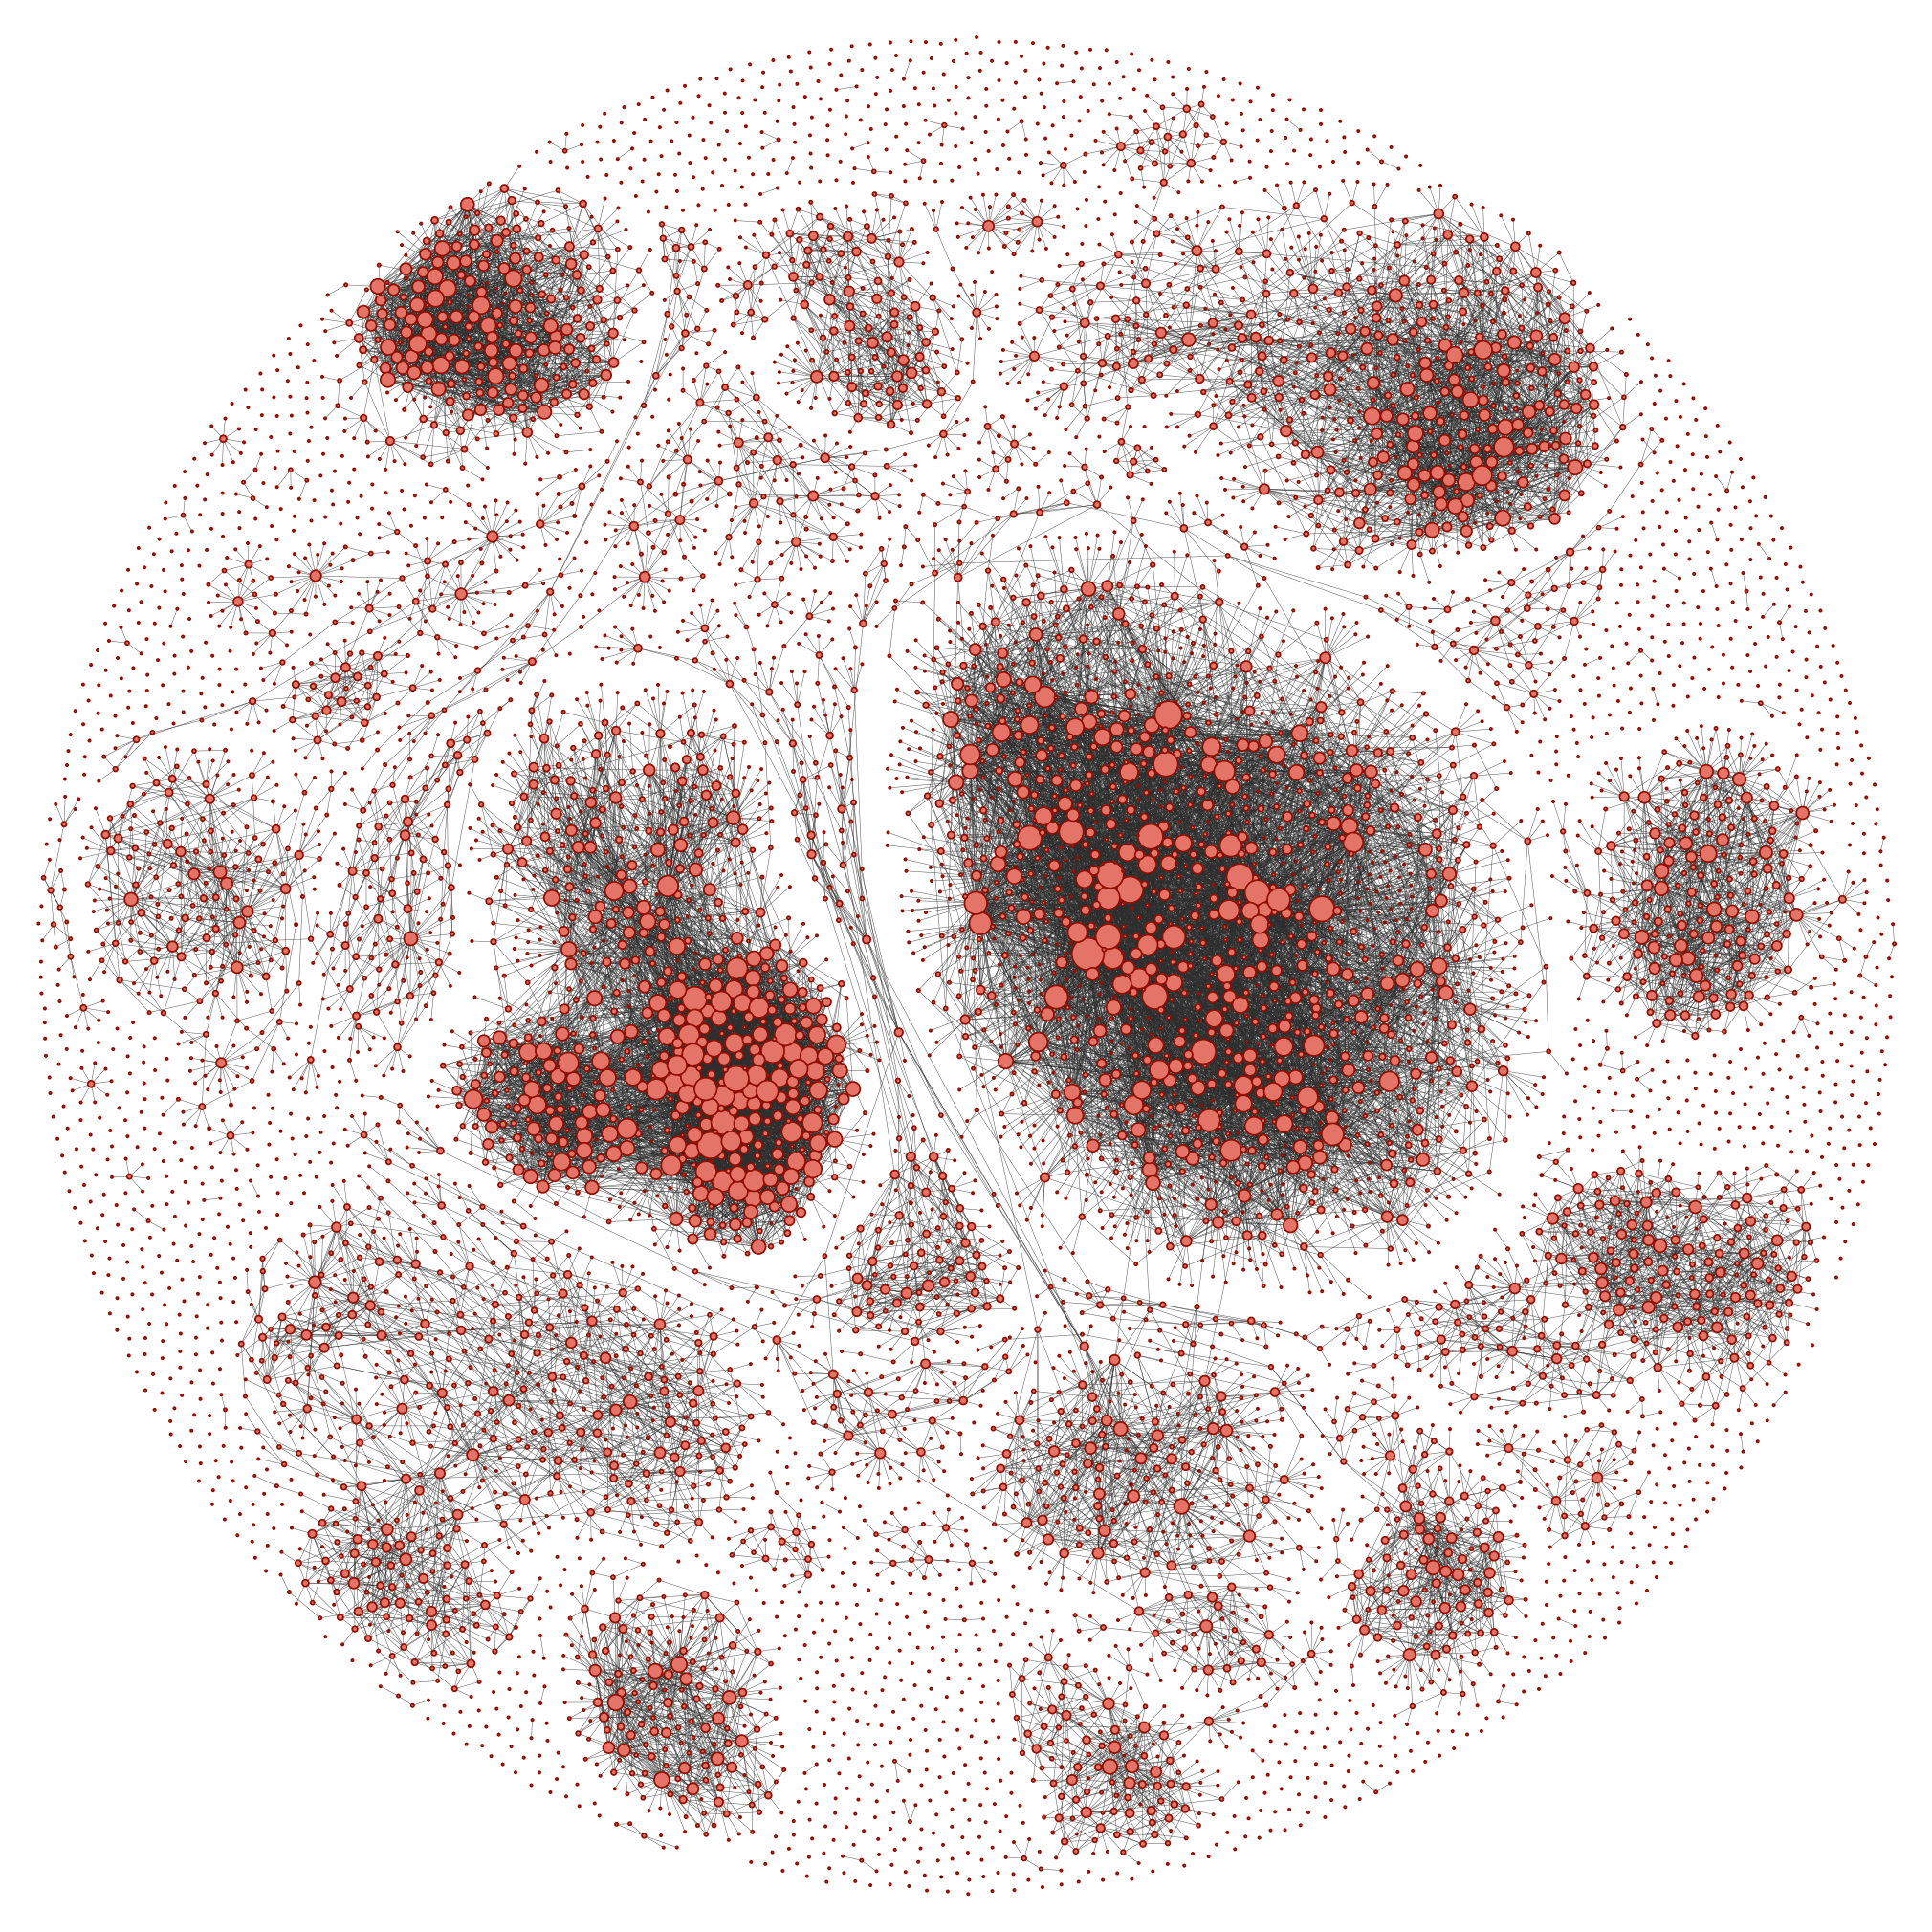

In [14]:
config_random_network = {
    # Input/output
    'zoom': 0.77,
    # Physics
    'node_charge': -58,
    'node_gravity': 0.85,
    'link_distance': 15,
    'link_distance_variation': 0,
    'node_collision': True,
    'wiggle_nodes': False,
    'freeze_nodes': False,
    # Nodes
    'node_fill_color': '#e57468',
    'node_stroke_color': '#920e00',
    'node_label_color': '#000000',
    'display_node_labels': False,
    'scale_node_size_by_strength': True,
    'node_size': 13.8,
    'node_stroke_width': 1,
    'node_size_variation': 0.5,
    # Links
    'link_color': '#2e2e2e',
    'link_width': 0.3,
    'link_alpha': 0.79,
    'link_width_variation': 0.5,
    # Thresholding
    'display_singleton_nodes': True,
    'min_link_weight_percentile': 0,
    'max_link_weight_percentile': 1
}


network, config = nw.visualize(G_rap_splittet, plot_in_cell_below=False, config=config_random_network)

fig, ax = nw.draw_netwulf(network, figsize=20)
plt.savefig("Network.pdf")


In [8]:
# Get degree (number of collaborations) for each artist
top_collaborators = sorted(G_pop.degree, key=lambda x: x[1], reverse=True)[:20]

# Print top 10
print("Top 10 artists with the most collaborations:")
for rank, (artist, degree) in enumerate(top_collaborators, start=1):
    print(f"{rank}. {artist} — {degree} collaborations")


Top 10 artists with the most collaborations:
1. R3HAB — 229 collaborations
2. Tiësto — 184 collaborations
3. David Guetta — 179 collaborations
4. Steve Aoki — 178 collaborations
5. Snoop Dogg — 167 collaborations
6. Diplo — 163 collaborations
7. Ty Dolla $ign — 162 collaborations
8. Gucci Mane — 159 collaborations
9. French Montana — 147 collaborations
10. Chris Brown — 136 collaborations
11. Lil Wayne — 135 collaborations
12. Pitbull — 131 collaborations
13. Major Lazer — 129 collaborations
14. MOTi — 117 collaborations
15. Sam Feldt — 114 collaborations
16. 2 Chainz — 113 collaborations
17. Wiz Khalifa — 113 collaborations
18. Rick Ross — 113 collaborations
19. Pritam — 110 collaborations
20. Afrojack — 107 collaborations


In [9]:
apply_louvain(G_rap)

Community 3: 1631 nodes
Community 12: 663 nodes
Community 18: 524 nodes
Community 0: 519 nodes
Community 7: 495 nodes
Community 66: 366 nodes
Community 1: 359 nodes
Community 22: 302 nodes
Community 21: 301 nodes
Community 49: 295 nodes
Community 2: 258 nodes
Community 19: 228 nodes
Community 32: 225 nodes
Community 15: 209 nodes
Community 17: 199 nodes
Community 24: 160 nodes
Community 31: 160 nodes
Community 36: 145 nodes
Community 30: 127 nodes
Community 130: 107 nodes
Community 25: 72 nodes
Community 27: 56 nodes
Community 9: 40 nodes
Community 136: 33 nodes
Community 57: 28 nodes
Community 97: 26 nodes
Community 67: 19 nodes
Community 46: 10 nodes
Community 54: 6 nodes
Community 59: 6 nodes
Community 62: 6 nodes
Community 244: 6 nodes
Community 272: 6 nodes
Community 141: 5 nodes
Community 144: 5 nodes
Community 163: 5 nodes
Community 71: 4 nodes
Community 85: 4 nodes
Community 128: 4 nodes
Community 164: 4 nodes
Community 179: 4 nodes
Community 206: 4 nodes
Community 257: 4 nodes

[(3,
  ['Benny The Butcher',
   'Kiana Ledé',
   'Tinashe',
   'Cardi B',
   'Common',
   'Lil Baby',
   'Likybo',
   'The Roots',
   'Young Stoner Life',
   'Chloe x Halle',
   'BLEU',
   'Cordae',
   'Ice Cube',
   '42 Dugg',
   'Rita Ora',
   'Nicki Minaj',
   'Only The Family',
   'JID',
   'Stunna 4 Vegas',
   'kizaru',
   'Logic',
   'Blueface',
   'Juicy J',
   'Nelly',
   'Moksi',
   '88GLAM',
   'Takeoff',
   'WHIPPED CREAM',
   'iLoveMemphis',
   'Culcha Candela',
   'Lupe Fiasco',
   'Good Times Ahead',
   'Lil Keed',
   'Fat Joe',
   'NorthSideBenji',
   'DDG',
   'Kevin Gates',
   'Bryce Vine',
   'Travis Barker',
   'Iyaz',
   'Rozei',
   'KR$NA',
   'Stefflon Don',
   'SpotemGottem',
   'Moneybagg Yo',
   'Migos',
   'Pusha T',
   'Playboi Carti',
   'Elijah Blake',
   'Lil Jon',
   'Mustard',
   'Lost Boyz',
   'Ms. Lauryn Hill',
   'Ambjaay',
   'Saweetie',
   'Pressa',
   'blackbear',
   'Rich Gang',
   '24Heavy',
   'Erica Banks',
   'Mike Posner',
   'Eve',
   'Outk